In [1]:
using MLDataPattern
using Plots; pyplot()
using ProgressMeter
using JLD
using DrakeVisualizer, GeometryTypes, CoordinateTransformations
DrakeVisualizer.any_open_windows() || DrakeVisualizer.new_window()

true

In [2]:
import Nets
reload("Nets")

In [3]:
include("../../pympc.jl")
colmat = PyMPC.colmat

Test Summary:    | Pass  Total
test sensitivity |  267    267


colmat (generic function with 1 method)

In [4]:
sys = PyMPC.Models.Pendulum(PyMPC.Models.PendulumParams{Float64}(t_s=0.2, u_min=[-2]))

PyMPC.Models.Pendulum{Float64}(PyObject <pympc.dynamical_systems.DTPWASystem object at 0x139146cd0>, PyMPC.Models.PendulumParams{Float64}
  m: Float64 1.0
  l: Float64 1.0
  g: Float64 9.81
  t_s: Float64 0.2
  bin_angle: Float64 1.5707963267948966
  x_min: Array{Float64}((2,)) [-6.28319, -31.4159]
  x_max: Array{Float64}((2,)) [6.28319, 31.4159]
  u_min: Array{Float64}((1,)) [-2.0]
  u_max: Array{Float64}((1,)) [2.0]
, PyCall.PyObject[PyObject <pympc.geometry.Polytope instance at 0x132cdcea8>, PyObject <pympc.geometry.Polytope instance at 0x132d4e7a0>, PyObject <pympc.geometry.Polytope instance at 0x132c11128>, PyObject <pympc.geometry.Polytope instance at 0x13319c758>, PyObject <pympc.geometry.Polytope instance at 0x13319c6c8>, PyObject <pympc.geometry.Polytope instance at 0x13906e128>, PyObject <pympc.geometry.Polytope instance at 0x13906ef38>, PyObject <pympc.geometry.Polytope instance at 0x13906e4d0>, PyObject <pympc.geometry.Polytope instance at 0x13906e0e0>], PyCall.PyObject[PyO

In [5]:
vis = Visualizer()[:pendulum]
setgeometry!(vis, sys)
settransform!(vis, sys, [0, 0])

Set{Array{Symbol,1}}()

In [6]:
# x0 = [π - π/3, 0.0]
# xs = PyMPC.Models.simulate(sys, x0, x -> [0.0], N_sim=30);
# PyMPC.Models.playback(vis, sys, xs);

In [7]:
controller = PyMPC.Models.controller(sys; N=20)

PyObject <pympc.control.MPCHybridController instance at 0x13904f9e0>

In [8]:
x0 = [π - 0.1, 0.0]
result = controller[:feedforward](colmat(x0))

(Any[[1.97016], [2.0], [2.0], [-1.73141], [-2.0], [-2.0], [-2.0], [-2.0], [-2.0], [-2.0], [-2.0], [-2.0], [-2.0], [-2.0], [-2.0], [-2.0], [-2.0], [-1.51003], [-1.10743], [-0.850567]], Any[[3.04159; 0.0], [3.04159; 0.590231], [3.15964; 1.18643], [3.39693; 1.55102], [3.70713; 0.70378], [3.84789; -0.805804], [3.68673; -2.59155], [3.16841; -4.0611], [2.35619; -4.51373], [1.45345; -3.37278]  …  [0.416739; -0.682585], [0.280222; -0.264943], [0.227234; -0.115147], [0.204204; -0.0693143], [0.190341; -0.0686655], [0.176608; -0.0952155], [0.157565; -0.14871], [0.127823; -0.141573], [0.0995087; -0.112269], [0.0770548; -0.0871468]], 1658.6121946808844, (6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4))

In [9]:
PyMPC.Models.playback(vis, sys, vec.(result[2]));

In [10]:
# x0 = [π - 0.1, 0.0]
# xs = PyMPC.Models.simulate(sys, x0, controller, N_sim=50);

# PyMPC.Models.playback(vis, sys, xs);

In [11]:
# num_samples = 100
# data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

# @showprogress for i in 1:num_samples
#     while true
#         x0 = PyMPC.Models.generate_x0(sys)
#         u, J, x_traj = PyMPC.run_mpc(controller, x0)
#         if !isnan(u[1])
#             PyMPC.Models.playback(vis, sys, vec.(x_traj))
#             push!(data, (x0, hcat(u, J[1:length(u), :])))
#             for x in x_traj
#                 u, J, _ = PyMPC.run_mpc(controller, vec(x))
#                 if !isnan(u[1])
#                     push!(data, (vec(x), hcat(u, J[1:length(u), :])))
#                 end
#             end
#             break
#         end
#     end
# end

# save("pendulum_100_traj.jld", "data", data)

In [12]:
data = load("pendulum_100_traj.jld")["data"]
train_data, test_data = splitobs(shuffleobs(data), 0.5)

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

AffineMap([0.333333], [0.0])

In [13]:
widths = [2, 16, 16, 16, 1]

function sensitive_loss(λ)
    q = fill(λ, widths[1])
    q[1] = 1.0 - λ
    (params, x, y) -> sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params)), x) .- y))
end

sensitive_loss (generic function with 1 method)

In [14]:
start_params = 0.1 * randn(Nets.Params{Float64}, widths).data
nepoch = 200;

mean((xy->begin  # In[34], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 6.01358930575874


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

mean((xy->begin  # In[34], line 16:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.7142418826006318


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43



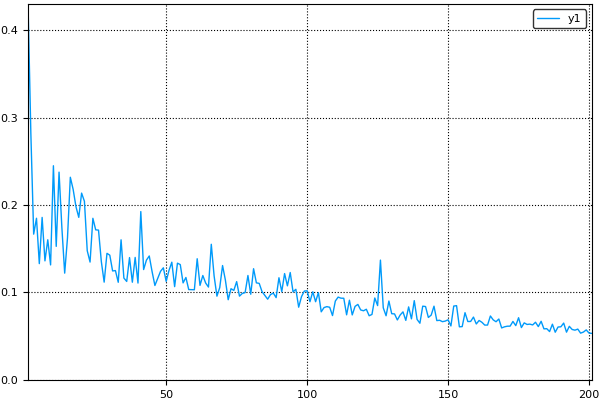

In [34]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

train_loss = sensitive_loss(0.5)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
#     train_loss = sensitive_loss(0.1)
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.99^i, batch_size=10))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, losses[1]))

In [35]:
netcontroller = x -> clamp.(net(x), sys.params.u_min, sys.params.u_max)

(::#33) (generic function with 1 method)

In [36]:
sim_sys = sys = PyMPC.Models.Pendulum(PyMPC.Models.PendulumParams{Float64}(t_s=0.1, bin_angle=π/8, u_min=[-2]));

In [42]:
x0 = PyMPC.Models.generate_x0(sys)
for i in 1:100
    x0 = PyMPC.Models.generate_x0(sys)
    if !any(isnan, controller[:feedback](colmat(x0)))
        break
    end
end
@show x0

x0 = [2.75322, 2.55413]


2-element Array{Float64,1}:
 2.75322
 2.55413

In [43]:
xs = PyMPC.Models.simulate(sim_sys, x0, netcontroller; N_sim=100)
PyMPC.Models.playback(vis, sys, xs)

In [44]:
xs = vcat(xs, PyMPC.Models.simulate(sim_sys, xs[end], netcontroller; N_sim=100))
PyMPC.Models.playback(vis, sys, xs)